# Data preparation with Datumaro

Datumaro is the open-source data management framework for computer vision and , making easy to import and export along with desired formats. Specifically, Datumaro provides more than 50 public data formats, e.g., MS-COCO, Pascal-VOC, YOLO-Ultralytics, Roboflow, CVAT, Cityscapes, etc. Please refer here for the details.

Moreover, Datumaro provides data manipulation functionalities such as filtration, transformation, subset appregation/split. Plus, data visualization and exploration are possible with Datumaro! Please enjoy basic/intermediate/advanced skills at here.

We here provide an example to import Corona NLP dataset and convert this to PyTorch dataset directly. After that, we can easily run training and validation for conventional text classification task on PyTorch framework.

## Install Datumaro package

<!-- !pip install datumaro==1.7.0 -->

## Import a dataset

The dataset is organized in the following directory structure:

```
.
├── Corona_NLP_test.csv
└── Corona_NLP_train.csv
```

In our `corona_nlp` folder, we've got two CSV files: `Corona_NLP_train.csv` and `Corona_NLP_test.csv`. These files hold the training and testing data for our Corona NLP dataset. I used `datumaro` to inspect the dataset directory structure, and it appears that the dataset is in tabular format.

In [1]:
import datumaro as dm
from datumaro.components.environment import DEFAULT_ENVIRONMENT

data_path = "~/data"
detected_formats = DEFAULT_ENVIRONMENT.detect_dataset(data_path)
detected_formats

/home/sooah/.pyenv/versions/datum/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['tabular']

To load our dataset using Datumaro, we'll need to specify the encoding as 'latin1' since the dataset is encoded in that format. We'll need to include `import_kwargs` to handle this:

In [2]:
import_kwargs = {"encoding": "latin1"}
dm_dataset = dm.Dataset.import_from(data_path, detected_formats[0], **import_kwargs)
dm_dataset

Dataset
	size=2000
	source_path=/home/sooah/data/corona_nlp_1k
	media_type=<class 'datumaro.components.media.TableRow'>
	ann_types=set()
	annotated_items_count=0
	annotations_count=0
subsets
	test: # of items=1000, # of annotated items=0, # of annotations=0
	train: # of items=1000, # of annotated items=0, # of annotations=0
infos
	categories
	14: []

Based on the information provided,
- The total size of the dataset is 44955 items.
- The dataset is divided into two subsets:
  - The 'Corona_NLP_test' subset contains 3798 items.
  - The 'Corona_NLP_train' subset contains 41157 items.

This breakdown gives us insight into the scale of our dataset and the distribution of items across its subsets.

### Setting Input and Output Targets for Sentiment Analysis

Moreover, we tried to take sentiment analysis for this dataset, so we have to set input and output targets for the dataset.

**For Input (Features)**:
- **Original Tweet**: This field contains the content of each tweet. When performing sentiment analysis, text data is used as the input for the model. Each tweet's content is tokenized, preprocessed, and then provided to the model.
- **Location (Optional)**: This field represents the location of the user who posted the tweet. Some models can utilize location information as additional features to enhance performance. However, the use of this field is optional and depends on the model.

**For Output (Target)**:
- **Sentiment**: This field indicates the sentiment of each tweet. The goal of sentiment analysis is to classify the sentiment of text, making this field the output target for the model. Sentiments are typically classified as positive, negative, or neutral, and the model aims to predict them.

Therefore, for the input of the sentiment analysis model, we will use the 'OriginalTweet' field to represent the content of each tweet. For the output, we will use the 'Sentiment' field to represent the sentiment of each tweet. The 'Location' field is optional and may or may not be used, depending on the model.


In [3]:
corona_nlp_target = {"input": ["OriginalTweet", "Location"], "output": "Sentiment"}
dm_dataset = dm.Dataset.import_from(
    data_path, detected_formats[0], target=corona_nlp_target, **import_kwargs
)
dm_dataset

Dataset
	size=2000
	source_path=/home/sooah/data/corona_nlp_1k
	media_type=<class 'datumaro.components.media.TableRow'>
	ann_types={<AnnotationType.tabular: 14>}
	annotated_items_count=2000
	annotations_count=2000
subsets
	test: # of items=1000, # of annotated items=1000, # of annotations=1000
	train: # of items=1000, # of annotated items=1000, # of annotations=1000
infos
	categories
	14: ['Sentiment']

It's worth noting that each item in the dataset now includes annotations for the output target we've defined. This means that the dataset has been updated to include annotations corresponding to the target output we've set.

By having annotations for the output target, we can track and utilize the labeled sentiment information associated with each data item. This update enhances the dataset's utility for sentiment analysis tasks, allowing for more effective model training and evaluation.


Now, let's take a peek at the first item in our dataset.

In [4]:
dm_dataset[0]

DatasetItem(id='0@test', subset='test', media=TableRow(row_idx:0, data:{'OriginalTweet': 'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1', 'Location': 'NYC', 'Sentiment': 'Extremely Negative'}), annotations=[Tabular(id=0, attributes={}, group=0, object_id=-1, values={'Sentiment': 'Extremely Negative'})], attributes={})

To check the media of the DatasetItem, we can check like below:

In [5]:
print("media : ", dm_dataset[0].media.data())
print("annotations : ", dm_dataset[0].annotations)

media :  {'OriginalTweet': 'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1', 'Location': 'NYC', 'Sentiment': 'Extremely Negative'}
annotations :  [Tabular(id=0, attributes={}, group=0, object_id=-1, values={'Sentiment': 'Extremely Negative'})]


We can confirm that the columns we've designated as output targets are present in the dataset's media. Furthermore, the output targets are stored as annotations within the data.

This indicates that the dataset has been structured to include the designated `target` columns in the `media`, and the `output` target information is available as `annotations` associated with each data item.


### Transforming Dataset Annotations for Sentiment Analysis Task

Our objective is to prepare the dataset for sentiment analysis, where sentiment serves as the label. To achieve this, we'll update the annotation type of the dataset items. The current annotation type of 'Tabular' is not ideal for sentiment analysis. Hence, we'll transform the dataset to better suit our task.

This transformation step is crucial to ensure that our dataset is properly formatted and ready for sentiment analysis model training and evaluation.


In [6]:
dm_dataset = dm_dataset.transform("astype_annotations")
dm_dataset

Dataset
	size=2000
	source_path=/home/sooah/data/corona_nlp_1k
	media_type=<class 'datumaro.components.media.TableRow'>
	ann_types={<AnnotationType.label: 1>}
	annotated_items_count=2000
	annotations_count=2000
subsets
	test: # of items=1000, # of annotated items=1000, # of annotations=1000
	train: # of items=1000, # of annotated items=1000, # of annotations=1000
infos
	categories
	1: ['Sentiment:Extremely Negative', 'Sentiment:Extremely Positive', 'Sentiment:Negative', 'Sentiment:Neutral', 'Sentiment:Positive']

In [7]:
print("annotations : ", dm_dataset[0].annotations)

annotations :  [Label(id=0, attributes={}, group=0, object_id=-1, label=0)]


We can observe that the sentiment labels have been included in the dataset categories, indicating the presence of sentiment-related labels. This inclusion is crucial as it allows us to understand the categories or classes that the dataset encompasses, particularly in terms of sentiment analysis.

Furthermore, we can confirm that these sentiment labels are reflected in the annotations of each dataset item. This ensures that the sentiment information associated with each item has been appropriately integrated into the dataset, laying the groundwork for sentiment analysis tasks.


### Exploring Dataset Characteristics

Having transformed the data as described above, we'll now explore the characteristics of the dataset. To begin, we'll use Datumaro's Validator to understand various features and attributes of the dataset.

Using the Validator, we can:
- Determine the number of columns included in the dataset and identify the type of each feature.
- Check for missing values or outliers, thereby understanding the dataset's structure.
- Analyze the distribution of the target variable to identify any class imbalance issues.
- Calculate basic statistical measures to understand the central tendency and dispersion of the data.

If you want to learn more about the conditions set in the Validator, please check [this link](https://openvinotoolkit.github.io/datumaro/latest/docs/level-up/intermediate_skills/08_data_validate.html).

This step will help us gain insights into the structure and properties of our data, setting the stage for effective analysis and modeling.

In [8]:
from datumaro.plugins.validators import TabularValidator

validator = TabularValidator(
    few_samples_thr=1,
    imbalance_ratio_thr=50,
    far_from_mean_thr=5.0,
    dominance_ratio_thr=0.8,
    topk_bins=0.1,
)
stats = validator.compute_statistics(dm_dataset)

### Dataset Statistics

The dataset statistics are as follows:

- **Total number of annotations**: This represents the total number of annotations present in the dataset.
- **Number of items with no annotations**: This indicates the number of items that do not have any annotations.
- **Number of items with some missing annotations**: This shows the number of items that are missing some of their annotations.

In Datumaro, annotations are categorized based on their characteristics, such as labels or captions, and their distribution can be analyzed accordingly. For this dataset, since we have set sentiment as the target, only label annotations are present.


Statistics summary
Total number of annotation :  2000
The number of items without any annotation :  0
The number of items with missing annotation :  0


Result of label distribution
   Sentiment:Extremely Negative  Sentiment:Extremely Positive  \
0                           309                           310   

   Sentiment:Negative  Sentiment:Neutral  Sentiment:Positive  
0                 568                318                 495  
The number of empty label for Sentiment is 0




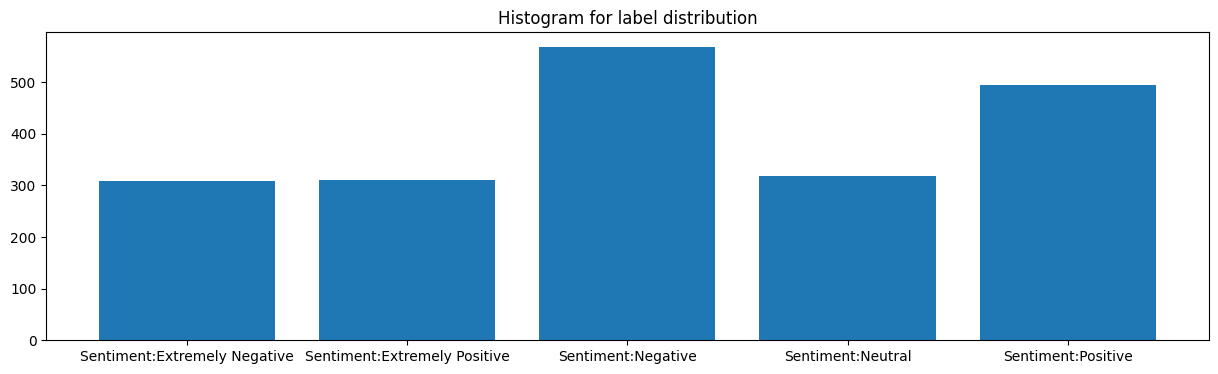

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


def show_stats(stats):
    print("Statistics summary")

    total_ann_count = stats["total_ann_count"]
    len_missing_ann_items = len(stats["items_missing_annotation"])
    len_broken_ann_items = len(stats["items_broken_annotation"])
    print("Total number of annotation : ", total_ann_count)
    print("The number of items without any annotation : ", len_missing_ann_items)
    print("The number of items with missing annotation : ", len_broken_ann_items)
    print("\n")

    defined_labels = stats["label_distribution"]["defined_labels"]
    if len(defined_labels) != 0:
        print("Result of label distribution")
        df_defined_labels = pd.DataFrame.from_dict([defined_labels])
        print(df_defined_labels)
        for key, value in stats["label_distribution"]["empty_labels"].items():
            print(f"The number of empty label for {key} is {value['count']}")
    plt.figure(figsize=(15, 4))
    plt.title("Histogram for label distribution")
    plt.bar(defined_labels.keys(), defined_labels.values())

    print("\n")
    defined_captions = stats["caption_distribution"]["defined_captions"]
    if len(defined_captions) != 0:
        print("Result of caption distribution")
        df_defined_captions = pd.DataFrame.from_dict([defined_captions])
        print(df_defined_captions)
        for key, value in stats["caption_distribution"]["empty_captions"].items():
            print(f"The number of empty caption for {key} is {value['count']}")
    return


show_stats(stats)

We can observe that the distribution among classes is uneven, with the 'positive' class having the largest proportion. This detailed statistical overview helps us understand the composition and completeness of the dataset, guiding further analysis and preprocessing steps.

Since this dataset has no empty labels, items with missing annotations, or items with broken annotations, the focus should be on cleaning the input data rather than the labels.

In [10]:
dm_dataset[0].media.data()

{'OriginalTweet': 'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1',
 'Location': 'NYC',
 'Sentiment': 'Extremely Negative'}

In [11]:
before = dm_dataset[100].media.data()
before

{'OriginalTweet': '@NileshShah68 I have summarized the most important points from the paper in this thread:\r\r\nhttps://t.co/dTZg4vg8VM',
 'Location': 'Hyderabad, India',
 'Sentiment': 'Positive'}

Datumaro provides a transform called `clean` that can be used for data cleaning. This transform helps in preparing the dataset for analysis by addressing various data quality issues. The `clean` transform modifies the media of items without validation and simultaneously cleans the annotations. If you want to clean the input media, it is recommended to use the `clean` function.

In our case, since the dataset does not have any empty labels, items with missing annotations, or items with broken annotations, we will focus on cleaning the input data. Using the `clean` transform, we can ensure that the input information is properly formatted and free from inconsistencies.

This step is crucial to maintain the quality and integrity of the data, which in turn, enhances the performance of the sentiment analysis model.

In [12]:
result = dm_dataset.transform("clean")

In [13]:
result[0].media.data

{'OriginalTweet': 'trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn soldout online grocers foodkick maxdelivery coronavirusfearing shoppers stock',
 'Location': 'nyc',
 'Sentiment': 'Extremely Negative'}

In [14]:
after = result[100].media.data
after

{'OriginalTweet': 'nileshshah summarized important points paper thread',
 'Location': 'hyderabad india',
 'Sentiment': 'Positive'}

After applying the `clean` transform, we can observe that the existing input media have been refined. If the same target is included in both the input and the output, the annotations will also be updated accordingly.

In [15]:
print("Before Clean : ", before["OriginalTweet"])
print("After Clean : ", after["OriginalTweet"])

Before Clean :  @NileshShah68 I have summarized the most important points from the paper in this thread:
https://t.co/dTZg4vg8VM
After Clean :  nileshshah summarized important points paper thread


## Convert Datumaro dataset into PyTorch dataset

In [16]:
train_iter = iter([value.media.data["OriginalTweet"] for value in result])

In [17]:
from datumaro.plugins.framework_converter import FrameworkConverter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(train_iter, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_dataset = FrameworkConverter(result, subset="train", task="tabular")
dm_torch_train_dataset = train_dataset.to_framework(
    framework="torch", target={"input": "OriginalTweet"}, tokenizer=tokenizer, vocab=vocab
)
val_dataset = FrameworkConverter(result, subset="test", task="tabular")
dm_torch_val_dataset = val_dataset.to_framework(
    framework="torch", target={"input": "OriginalTweet"}, tokenizer=tokenizer, vocab=vocab
)

2024-10-16 16:36:27.631387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 16:36:27.645753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 16:36:27.649957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 16:36:27.659912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 16:36:28.583817: W tensorflow/compiler/tf2

# 4. Modeling

- Showcase how to use your tool for tasks such as feature extraction, model training, or evaluation on the dataset.
- Compare it with standard methods to show its advantages.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple RNN-based model for text classification


class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.rnn(x)
        out = self.fc(hidden[-1])
        return out


# Example: Model initialization
vocab_size = len(vocab)  # This should be the size of your vocabulary
embed_size = 128
hidden_size = 256
output_size = 5  # Assume we have 3 sentiment classes: positive, neutral, negative

model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

/home/sooah/.pyenv/versions/datum/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [19]:
import numpy as np
from torch.utils.data import DataLoader

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def custom_collate_fn(batch):
    # Separate inputs and outputs
    inputs, outputs = zip(*batch)

    # Find the maximum length in the inputs and outputs
    max_input_length = max(len(input_) for input_ in inputs)

    # Pad all inputs and outputs to the maximum length
    padded_inputs = [
        np.pad(input_, (0, max_input_length - len(input_)), mode="constant") for input_ in inputs
    ]

    # Convert to tensors
    padded_inputs = torch.tensor(padded_inputs, dtype=torch.long)
    padded_outputs = torch.stack(outputs)  # Assuming labels are integers for classification

    return padded_inputs, padded_outputs


# Create DataLoader for your dataset
train_loader = DataLoader(
    dm_torch_train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn
)
val_loader = DataLoader(dm_torch_val_dataset, batch_size=32, collate_fn=custom_collate_fn)

In [20]:
# Training Loop
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
        train_losses.append(running_loss)

        # Validation Loop (optional)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss)

        if epoch % 5 == 0:
            print(
                f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)} | Validation Loss: {val_loss/len(val_loader)}"
            )
    return train_losses, val_losses


# Run the training
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer)

/tmp/ipykernel_633257/52718613.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  padded_inputs = torch.tensor(padded_inputs, dtype=torch.long)


Epoch 1, Loss: 1.590895850211382 | Validation Loss: 1.5764841102063656
Epoch 2, Loss: 1.5879455283284187 | Validation Loss: 1.5764116831123829
Epoch 3, Loss: 1.581930335611105 | Validation Loss: 1.5686759762465954
Epoch 4, Loss: 1.5809518098831177 | Validation Loss: 1.5715479329228401
Epoch 5, Loss: 1.5830248109996319 | Validation Loss: 1.5709160640835762


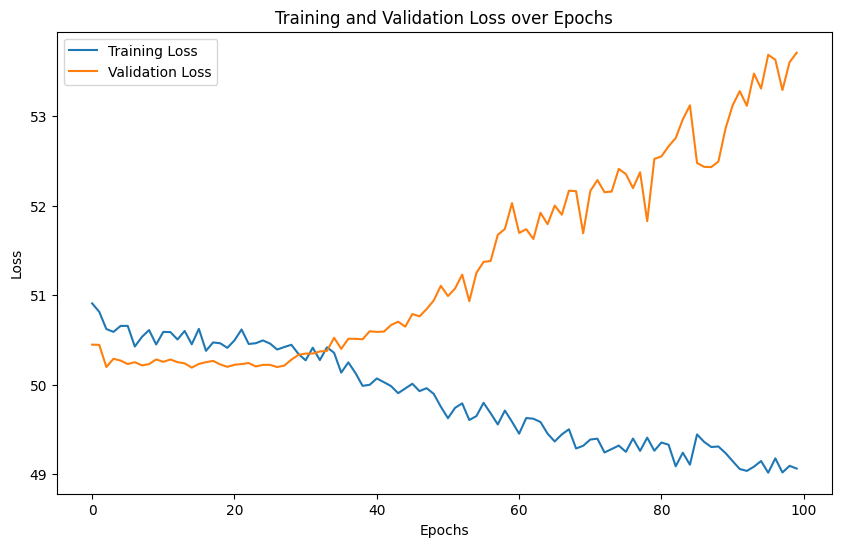

In [21]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()


# Assuming you have stored losses in lists
plot_loss(train_losses, val_losses)

In [22]:
! pip install seaborn

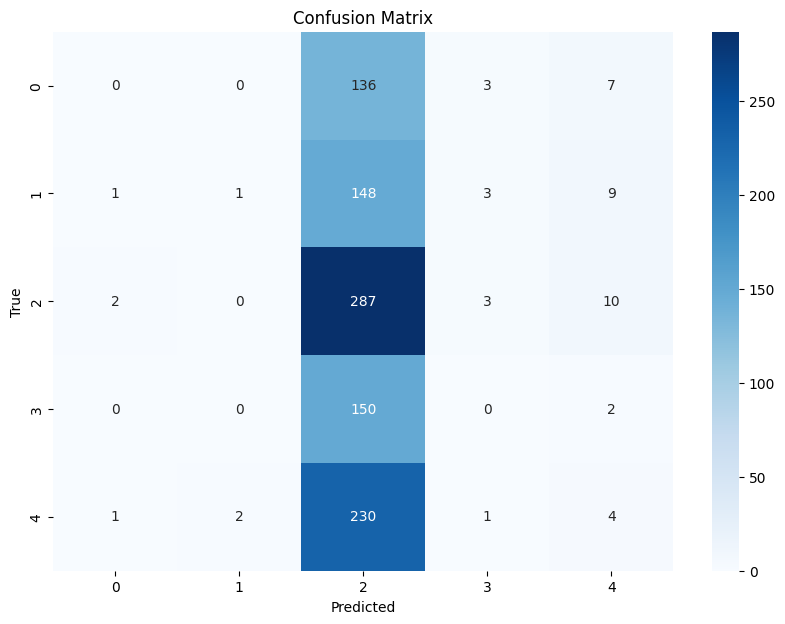

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, val_loader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(model, val_loader)

In [28]:
def per_class_accuracy(model, val_loader, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                label = labels[i]
                if preds[i] == label:
                    class_correct[label] += 1
                class_total[label] += 1

    for i in range(num_classes):
        print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")


# Assuming the dataset has 5 classes
per_class_accuracy(model, val_loader, 5)

Accuracy of class 0: 0.00%
Accuracy of class 1: 0.62%
Accuracy of class 2: 95.03%
Accuracy of class 3: 0.00%
Accuracy of class 4: 1.68%
